In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

handshake_df = pd.read_csv("./handshake.csv")
display(
    handshake_df.groupby(["kex", "auth"]).size(
    ).reset_index(name="count").sort_values(["kex", "auth"])
)

,kex,auth,count
0,hqc128,mldsa44-mldsa44-hqc128,3007
1,hqc128,mldsa44-mldsa44-mldsa44,3166
2,hqc128,sphincs128f-mldsa44-mldsa44,3105
3,mlkem512,mldsa44-mldsa44-mldsa44,3191
4,mlkem512,mldsa44-mldsa44-mlkem512,3279
5,mlkem512,sphincs128f-mldsa44-mldsa44,3317
6,secp256r1,rsa2048-rsa2048-rsa2048,3017
7,secp256r1,sha256ecdsa-sha256ecdsa-sha256ecdsa,3004
8,x25519,ed25519-ed25519-ed25519,3026


In [2]:
def plot_multiple_histograms(data_dict, bins=10, alpha=0.6, title=None):
    """
    Plots multiple histograms on the same figure for each label in the input dictionary.

    Parameters:
        data_dict (dict): A dictionary where keys are labels (str) and values are lists of integers.
        bins (int): Number of bins to use in the histograms.
        alpha (float): Transparency level for the histograms (0.0 to 1.0).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(15, 4))

    for label, values in data_dict.items():
        plt.hist(values, bins=bins, alpha=alpha, label=label)

    plt.title(title)
    plt.xlabel("Duration (microseconds)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


kex Total time              CPU time        
                 median        std     median     std
0     hqc128  1341054.5  303532.68  1321492.0   80.01
1   mlkem512    27254.0  284903.41    19443.0   85.32
2  secp256r1   445096.0  195745.12   438639.0  182.35
3     x25519    36322.5  713456.00    28813.0   31.68

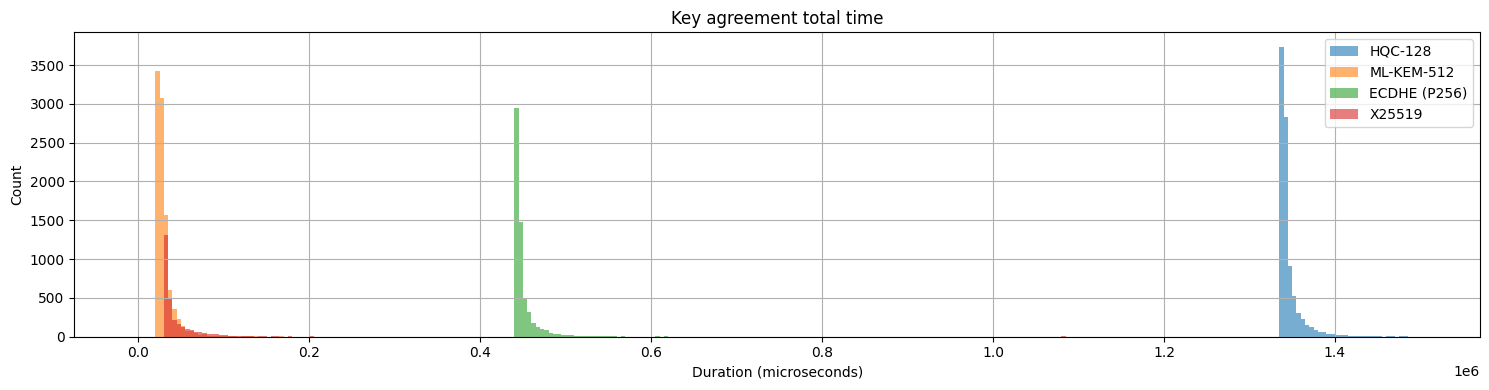

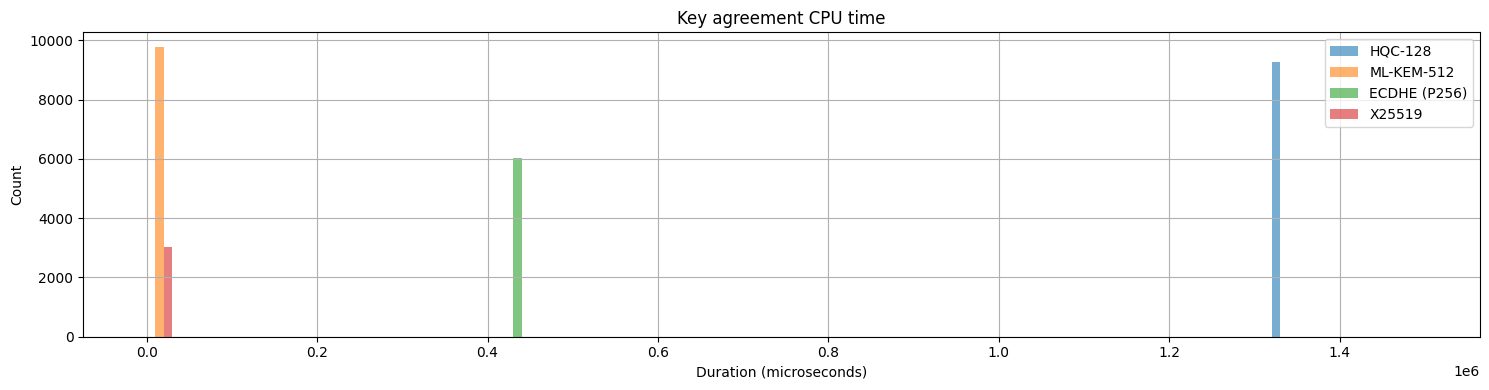

In [3]:
"""Key agreement performance: there are two important durations to keep track of
total duration is the time from handshake start to exiting DoTls13ServerHello
CPU duration is the time during which the CPU is doing crypto work, so it is the
total duration minus the time between "ClientHello sent" and "ServerHello done"
"""

kex_df = handshake_df[
    ["kex", "auth", "ch_start", "ch_sent", "sh_start", "sh_done"]].copy()
kex_df["ka_tot_dur"] = kex_df["sh_done"] - kex_df["ch_start"]
kex_df["ka_cpu_dur"] = (
    kex_df["ch_sent"] - kex_df["ch_start"] 
    + kex_df["sh_done"] - kex_df["sh_start"]
)
assert (kex_df["ka_tot_dur"] > 0).all() and (kex_df["ka_cpu_dur"] > 0).all()

summary = kex_df.groupby(["kex"]).agg({
    "ka_tot_dur": ["median", "std"],
    "ka_cpu_dur": ["median", "std"],
}).round(2).rename(
    columns={"ka_tot_dur": "Total time", "ka_cpu_dur": "CPU time"}
).reset_index()
display(summary)

plot_multiple_histograms(
    {
        "HQC-128": kex_df.loc[kex_df["kex"] == "hqc128", "ka_tot_dur"],
        "ML-KEM-512": kex_df.loc[kex_df["kex"] == "mlkem512", "ka_tot_dur"],
        "ECDHE (P256)": kex_df.loc[kex_df["kex"] == "secp256r1", "ka_tot_dur"],
        "X25519": kex_df.loc[kex_df["kex"] == "x25519", "ka_tot_dur"],
    },
    bins=list(range(0, 1_500_000, 5_000)),
    title="Key agreement total time"
)

plot_multiple_histograms(
    {
        "HQC-128": kex_df.loc[kex_df["kex"] == "hqc128", "ka_cpu_dur"],
        "ML-KEM-512": kex_df.loc[kex_df["kex"] == "mlkem512", "ka_cpu_dur"],
        "ECDHE (P256)": kex_df.loc[kex_df["kex"] == "secp256r1", "ka_cpu_dur"],
        "X25519": kex_df.loc[kex_df["kex"] == "x25519", "ka_cpu_dur"],
    },
    bins=list(range(0, 1_500_000, 10_000)),
    title="Key agreement CPU time"
)